In [4]:
import joblib

from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn import linear_model

from data import load_train_test_sets
from model import evaluate_model, create_pipeline
%matplotlib inline

## Define y_target and split train/test dataset

In [5]:
X_train, X_test, y_train, y_test = load_train_test_sets()

Proportion of popular books in the dataset: 0.07
75122


## Fit and Evaluation functions

We want to maximise for precision, given that a False Positive may be too costly for us.

## Model training and evaluation
### DummyModel

              precision    recall  f1-score   support

       False       0.93      1.00      0.96     98841
        True       0.00      0.00      0.00      7673

    accuracy                           0.93    106514
   macro avg       0.46      0.50      0.48    106514
weighted avg       0.86      0.93      0.89    106514

None


/Users/andreapereira/projects/codeop_data_science_bootcamp/goodreads_popularity_prediction/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andreapereira/projects/codeop_data_science_bootcamp/goodreads_popularity_prediction/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andreapereira/projects/codeop_data_science_bootcamp/goodreads_popularity_prediction/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-

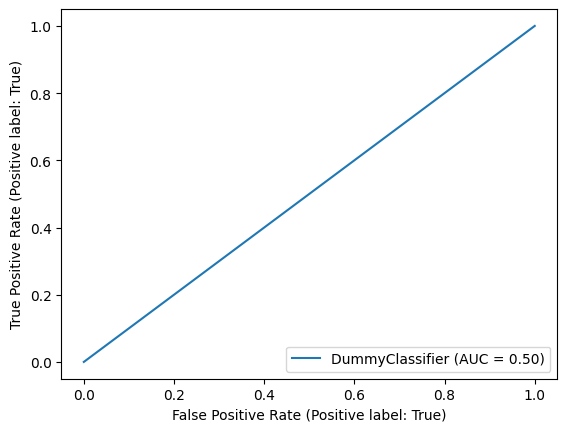

In [6]:
dummy_classifier = DummyClassifier()
dummy_classifier.fit(X_train, y_train)
print(evaluate_model(dummy_classifier,
                     X_test=X_test,
                     y_test=y_test))

### Logistic Regression

              precision    recall  f1-score   support

       False       0.93      1.00      0.96     98841
        True       0.00      0.00      0.00      7673

    accuracy                           0.93    106514
   macro avg       0.46      0.50      0.48    106514
weighted avg       0.86      0.93      0.89    106514



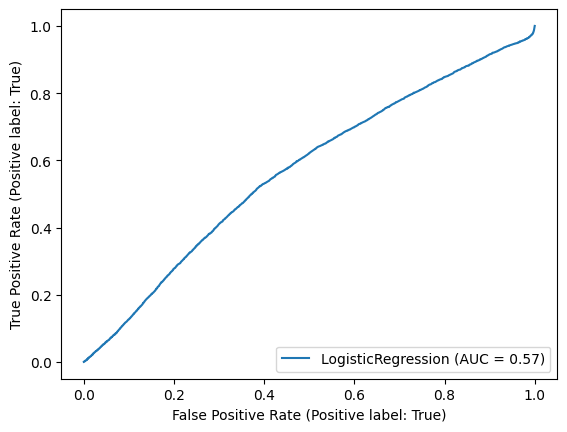

In [7]:
lr = linear_model.LogisticRegression()
lr.fit(X_train[['PublishYear', 'PagesNumber']], y_train)
evaluate_model(lr,
                     X_test=X_test[['PublishYear', 'PagesNumber']],
                     y_test=y_test)

## CountVectorizer

Let's introduce Scikit Learn Pipelines

In [8]:
model = create_pipeline()
model.fit(X_train.head(10000), y_train.head(10000))

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('description_bow',
                                                  CountVectorizer(max_df=0.05,
                                                                  min_df=50,
                                                                  stop_words={'english'}),
                                                  'Description'),
                                                 ('title_bow',
                                                  CountVectorizer(max_df=0.05,
                                                                  min_df=50,
                                                                  stop_words={'english'}),
                                                  'Name')])),
                ('svd', TruncatedSVD(n_components=50)),
                ('classifier', LogisticRegression(random_state=42))])

              precision    recall  f1-score   support

       False       0.93      1.00      0.96     98841
        True       0.38      0.03      0.06      7673

    accuracy                           0.93    106514
   macro avg       0.65      0.51      0.51    106514
weighted avg       0.89      0.93      0.90    106514



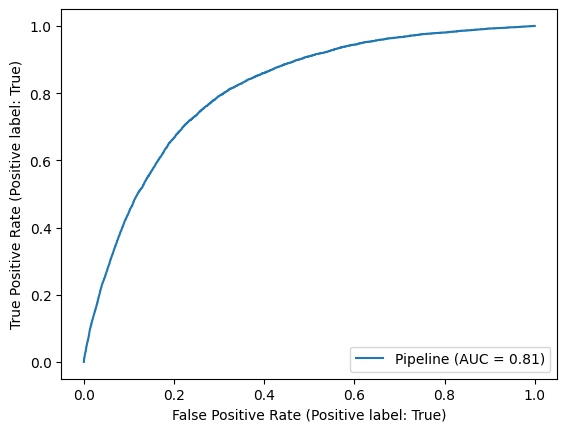

In [9]:
evaluate_model(model, X_test=X_test, y_test=y_test)

### Introducing GridsearchCV to explore hyperparameters

In [10]:
params = {
    'column_transformer__title_bow__min_df': (100, 500),
    'column_transformer__title_bow__max_df': (0.05, 0.1),
    'column_transformer__description_bow__min_df': (100, 500),
    'column_transformer__description_bow__max_df': (0.05, 0.1),
    'svd__n_components': (10, 50, 100)
}

random_search = RandomizedSearchCV(model, params, scoring='precision', n_jobs=-1, verbose=1)
random_search.fit(X_train.head(20000), y_train.head(20000))


random_search.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


0.3929032258064516

In [11]:
random_search.best_params_

{'svd__n_components': 100,
 'column_transformer__title_bow__min_df': 100,
 'column_transformer__title_bow__max_df': 0.1,
 'column_transformer__description_bow__min_df': 100,
 'column_transformer__description_bow__max_df': 0.05}

In [12]:
final_model = create_pipeline(params=random_search.best_params_)

In [13]:
final_model.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('description_bow',
                                                  CountVectorizer(max_df=0.05,
                                                                  min_df=100,
                                                                  stop_words={'english'}),
                                                  'Description'),
                                                 ('title_bow',
                                                  CountVectorizer(max_df=0.1,
                                                                  min_df=100,
                                                                  stop_words={'english'}),
                                                  'Name')])),
                ('svd', TruncatedSVD(n_components=100)),
                ('classifier', LogisticRegression(random_state=42))])

              precision    recall  f1-score   support

       False       0.93      0.99      0.96     98841
        True       0.45      0.06      0.11      7673

    accuracy                           0.93    106514
   macro avg       0.69      0.53      0.54    106514
weighted avg       0.90      0.93      0.90    106514



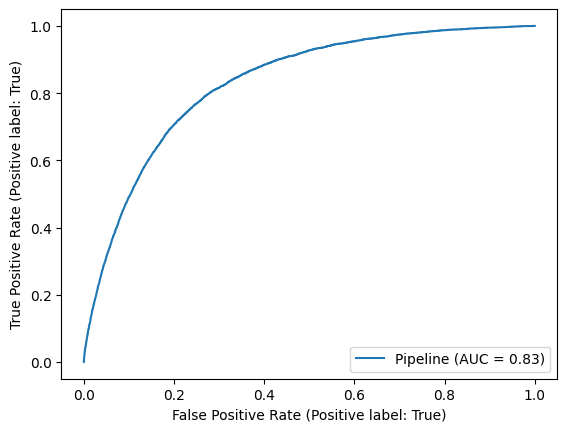

In [14]:
evaluate_model(final_model, X_test, y_test)

In [15]:
joblib.dump(final_model, '../models/final_model.clf')

['../models/final_model.clf']